In [3]:
# Upload and prepare dataset
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gilchr/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

import pandas as pd
df = pd.read_csv('dataset.csv')

# Combine and clean content
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['label'] = df['unreliable']
df = df[['title', 'text', 'content', 'label']]


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/gilchr/fake-and-real-news-dataset
License(s): MIT
  0% 0.00/43.4M [00:00<?, ?B/s]
100% 43.4M/43.4M [00:00<00:00, 557MB/s]
Archive:  fake-and-real-news-dataset.zip
  inflating: fake_real_news.csv      


In [4]:
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(lemmatizer.lemmatize(w) for w in words)

df['cleaned_content'] = df['content'].apply(preprocess)
df = df[df['cleaned_content'].str.split().str.len() > 5]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
# Replace NaN values with empty strings in training, validation, and test sets
X_train = X_train.fillna('')
X_val = X_val.fillna('')
X_test = X_test.fillna('')

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)



Logistic Regression Evaluation Metrics:
Training Accuracy: 0.9744170078579966
Testing Accuracy: 0.9547604516325908
Precision: 0.9507614963773473
Recall: 0.9611360239162929
F1 Score: 0.9559206125027875
Confusion Matrix:
 [[6085  333]
 [ 260 6430]]


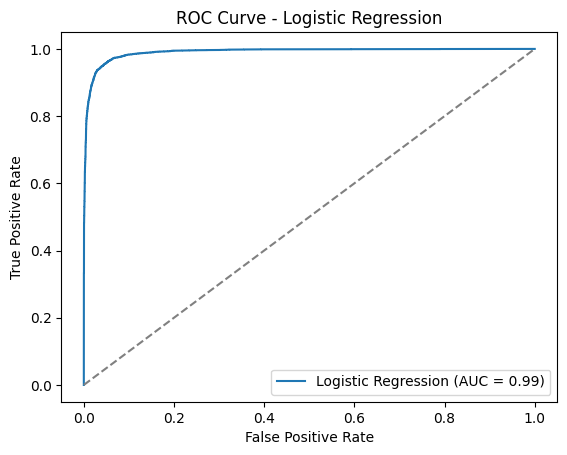


Random Forest Evaluation Metrics:
Training Accuracy: 0.9999491391806322
Testing Accuracy: 0.9415624046383888
Precision: 0.9305232558139535
Recall: 0.95695067264574
F1 Score: 0.9435519528371408
Confusion Matrix:
 [[5940  478]
 [ 288 6402]]


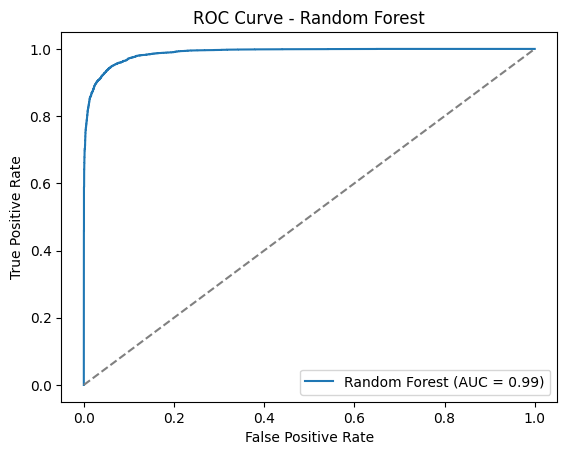


Gradient Boosting Evaluation Metrics:
Training Accuracy: 0.9336012003153371
Testing Accuracy: 0.9239395788831248
Precision: 0.9213915618060696
Recall: 0.9303437967115097
F1 Score: 0.9258460394198587
Confusion Matrix:
 [[5887  531]
 [ 466 6224]]


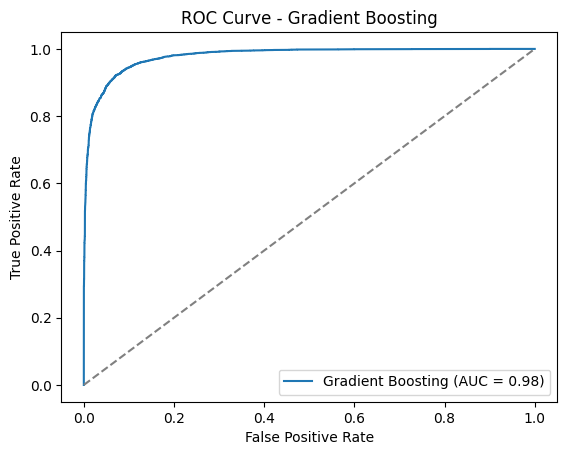

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)[:, 1]

    print(f"\n{name} Evaluation Metrics:")
    print("Training Accuracy:", accuracy_score(y_train, train_preds))
    print("Testing Accuracy:", accuracy_score(y_test, test_preds))
    print("Precision:", precision_score(y_test, test_preds))
    print("Recall:", recall_score(y_test, test_preds))
    print("F1 Score:", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000)
evaluate_model("Logistic Regression", log_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, max_depth=50, max_features='sqrt', random_state=42)
evaluate_model("Random Forest", rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
evaluate_model("Gradient Boosting", gb_model, X_train_tfidf, y_train, X_test_tfidf, y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 420s 672ms/step - accuracy: 0.8833 - loss: 0.2869 - val_accuracy: 0.9441 - val_loss: 0.1565
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 438s 666ms/step - accuracy: 0.9666 - loss: 0.1009 - val_accuracy: 0.9539 - val_loss: 0.1311
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 434s 653ms/step - accuracy: 0.9783 - loss: 0.0655 - val_accuracy: 0.9554 - val_loss: 0.1411
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 428s 696ms/step - accuracy: 0.9877 - loss: 0.0407 - val_accuracy: 0.9566 - val_loss: 0.1645
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 455s 718ms/step - accuracy: 0.9919 - loss: 0.0264 - val_accuracy: 0.9473 - val_loss: 0.1762
410/410 ━━━━━━━━━━━━━━━━━━━━ 36s 85ms/step
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 107s 87ms/step

LSTM Evaluation Metrics:
Training Accuracy: 0.9957022607634209
Testing Accuracy: 0.949420201403723
Precision: 0.9327875915553641
Recall: 0.9708520179372198
F1 Score: 0.951439244122171
Confusion Matrix:
 [[5950  468]
 [ 195 6495]]


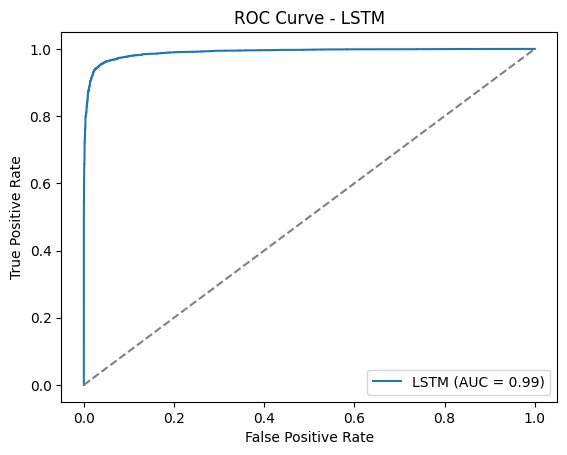

In [9]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# Parameters
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Tokenizing and padding
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Label encoding
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))

# LSTM model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train_pad, y_train_enc, validation_data=(X_val_pad, y_val_enc), epochs=10, batch_size=64, callbacks=[early_stop])

# Evaluate
y_pred_prob = model.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test_enc.argmax(axis=1)

train_pred_prob = model.predict(X_train_pad)
train_pred = train_pred_prob.argmax(axis=1)
train_true = y_train_enc.argmax(axis=1)

print("\nLSTM Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(train_true, train_pred))
print("Testing Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ROC for LSTM
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='LSTM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()


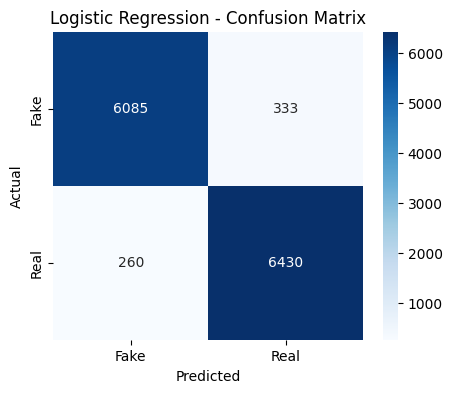

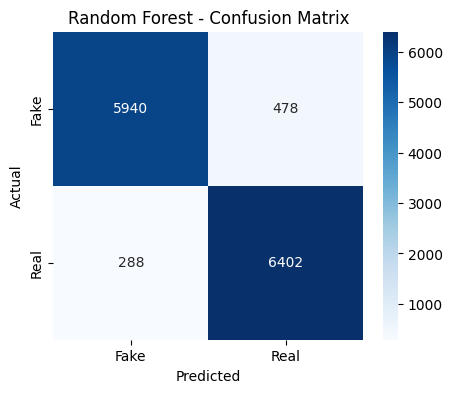

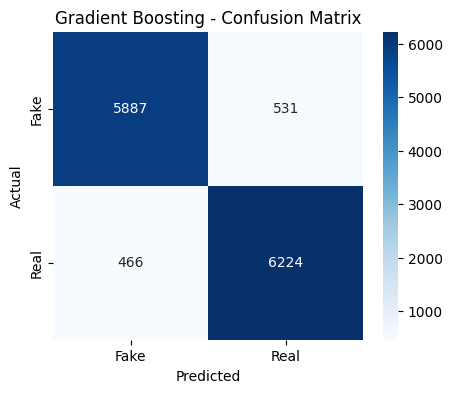

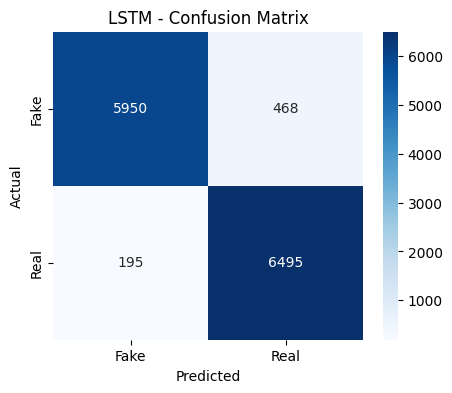

In [10]:
import seaborn as sns

def plot_confusion_matrix(model_name, y_true, y_pred, labels=['Fake', 'Real']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

# Plot for all models (update these variables if needed)
plot_confusion_matrix("Logistic Regression", y_test, log_model.predict(X_test_tfidf))
plot_confusion_matrix("Random Forest", y_test, rf_model.predict(X_test_tfidf))
plot_confusion_matrix("Gradient Boosting", y_test, gb_model.predict(X_test_tfidf))
plot_confusion_matrix("LSTM", y_true, y_pred)
